In [ ]:
import pm4py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.evaluation import algorithm as general_evaluation
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.process_tree import converter as process_tree_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

In [20]:
from pm4py.objects.bpmn.importer import factory as bpmn_importer
from pm4py.objects.conversion.bpmn import factory as bpmn_converter

ImportError: cannot import name 'factory' from 'pm4py.objects.bpmn.importer' (c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\pm4py\objects\bpmn\importer\__init__.py)

In [2]:
log = pm4py.read_xes('../data/BPI Challenge 2017.xes/BPI Challenge 2017.xes', return_legacy_log_object=True)

c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [01:41<00:00, 311.66it/s]


In [16]:
# retain only cases with a final decision by the bank

allowed_events = ["A_Pending", "A_Cancelled", "A_Denied"]

pruned_log = pm4py.filter_event_attribute_values(
    log,
    attribute_key="concept:name",
    values=allowed_events,
    level="case",
    retain=True
)

perc = 0.005
filtered_log = pm4py.filter_variants_by_coverage_percentage(pruned_log, perc)


# Mining

## Inductive Miner

In [24]:
process_tree = inductive_miner.apply(filtered_log)
ind_net, ind_im, ind_fm = process_tree_converter.apply(process_tree)

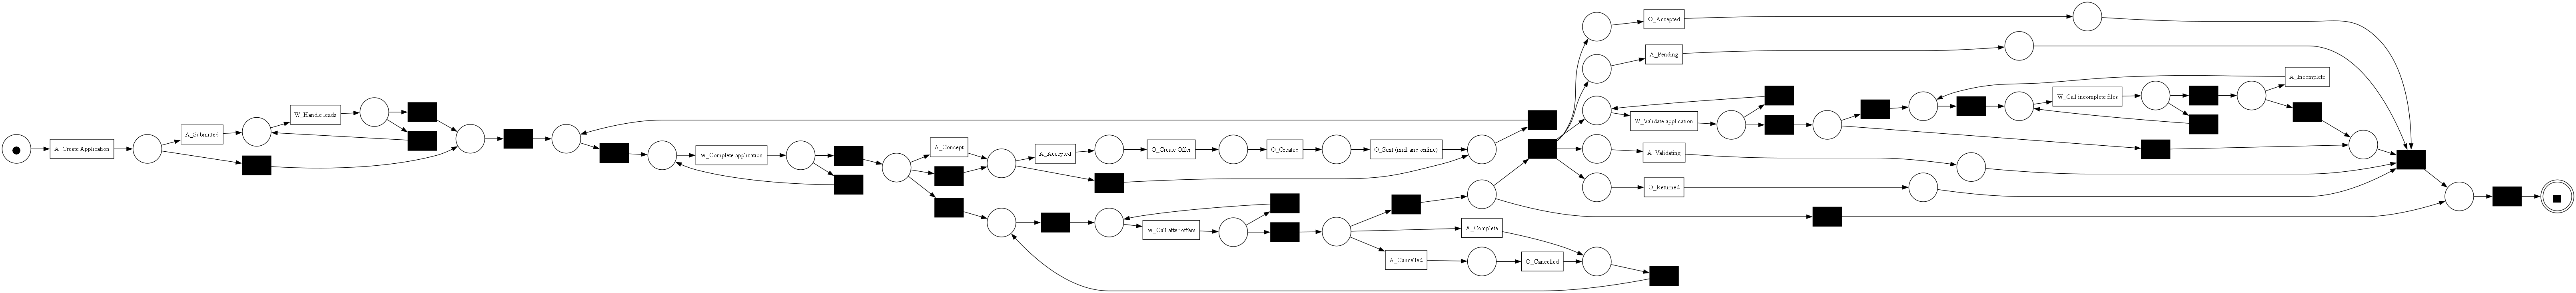

In [25]:
gviz = pn_visualizer.apply(ind_net, ind_im, ind_fm)
pn_visualizer.view(gviz=gviz)


## Heuristic Miner

In [18]:
heu_net, heu_im, heu_fm = heuristics_miner.apply(filtered_log)

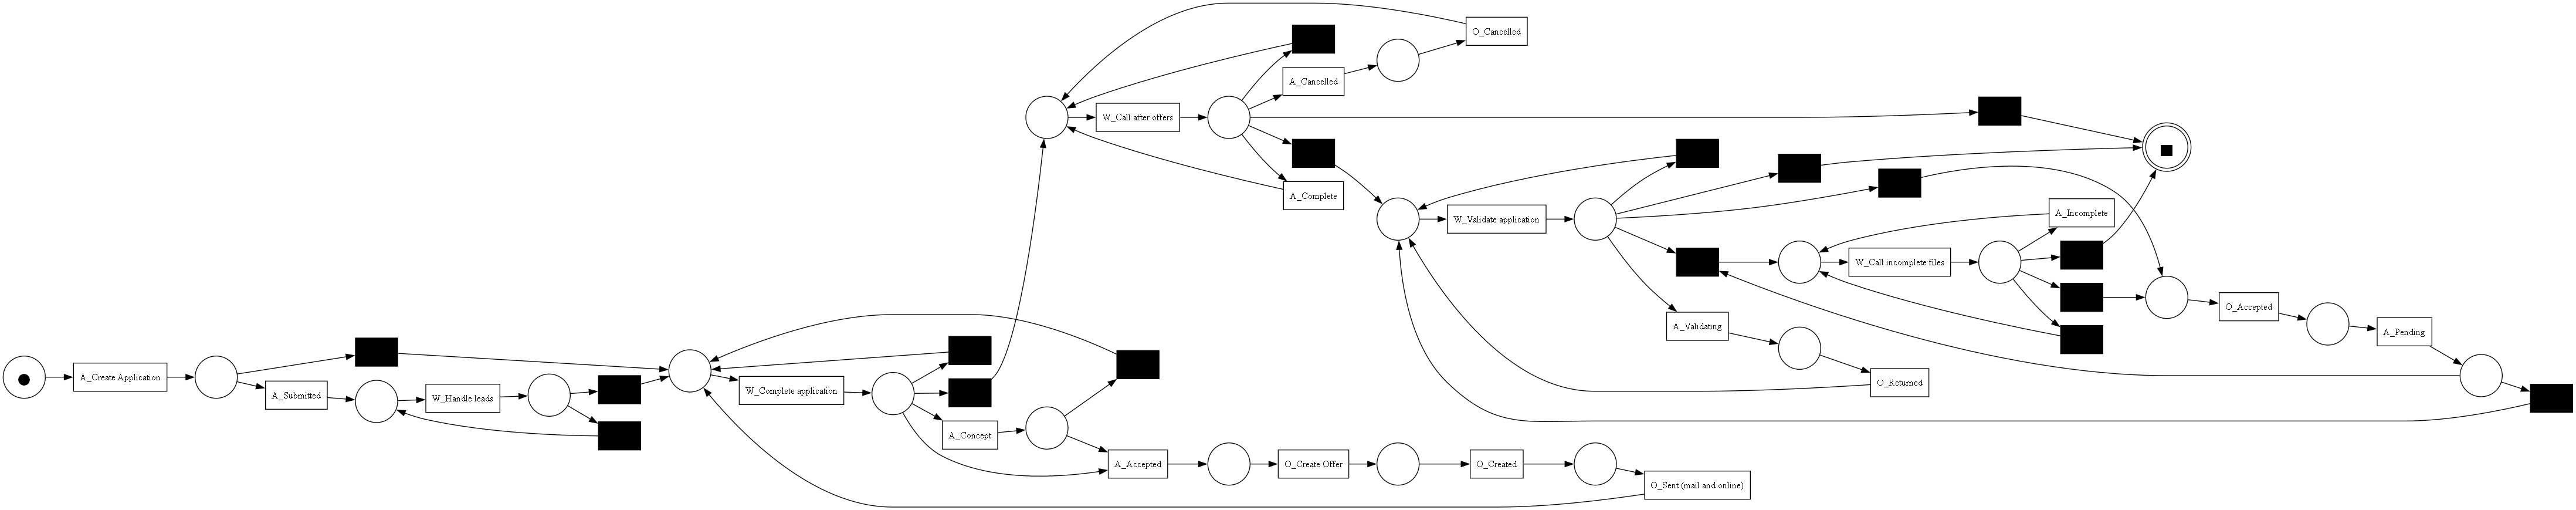

In [19]:
heu_gviz = pn_vis.apply(heu_net, heu_im, heu_fm)
pn_vis.view(heu_gviz)

# Evaluating the nets


1. Custom BPMN 
2. Heuristic mined net
3. Inductive mined net

In [22]:

bpmn_graph = pm4py.read_bpmn("Final Draft.bpmn")
cust_net, cust_im, cust_fm = pm4py.convert_to_petri_net(bpmn_graph)

In [23]:
def eval_and_print(name, net, im, fm, log):
    print(f"\nEvaluation: {name}")
    metrics = general_evaluation.apply(log, net, im, fm)
    for k, v in metrics.items():
        print(f"{k}: {v}")
    return metrics

In [27]:
metrics_heuristics = eval_and_print("Heuristics Miner net", heu_net, heu_im, heu_fm, pruned_log)
metrics_inductive  = eval_and_print("Inductive Miner net", ind_net, ind_im, ind_fm, pruned_log)
metrics_custom     = eval_and_print("Custom BPMN Final Draft net", cust_net, cust_im, cust_fm, pruned_log)


Evaluation: Heuristics Miner net


replaying log with TBR, completed traces :: 100%|██████████| 263029/263029 [03:30<00:00, 1248.20it/s]


fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.962863798779142, 'log_fitness': 0.9610800175530742, 'percentage_of_fitting_traces': 0.0}
precision: 0.6324790548451351
generalization: 0.9935092009398054
simplicity: 0.6344086021505377
metricsAverageWeight: 0.8053692188721382
fscore: 0.7628998405659573

Evaluation: Inductive Miner net


replaying log with TBR, completed traces :: 100%|██████████| 263029/263029 [08:23<00:00, 522.84it/s] 


fitness: {'perc_fit_traces': 32.85473241857948, 'average_trace_fitness': 0.9746847352714699, 'log_fitness': 0.9719181666689118, 'percentage_of_fitting_traces': 32.85473241857948}
precision: 0.4104602098053317
generalization: 0.9942426970985246
simplicity: 0.7190082644628099
metricsAverageWeight: 0.7739073345088945
fscore: 0.5771701024751494

Evaluation: Custom BPMN Final Draft net


replaying log with TBR, completed traces :: 100%|██████████| 263029/263029 [07:39<00:00, 572.01it/s] 


fitness: {'perc_fit_traces': 31.85826621247334, 'average_trace_fitness': 0.9798957080786437, 'log_fitness': 0.9780425572558142, 'percentage_of_fitting_traces': 31.85826621247334}
precision: 0.5289604341044398
generalization: 0.9714366434332946
simplicity: 0.663716814159292
metricsAverageWeight: 0.7855391122382102
fscore: 0.6865889697958518


# Custom simplicity measures:

In [30]:
def avg_edges(name, net):
    places = len(net.places)
    arcs = len(net.arcs)
    print(f"{name}: places={places}, arcs={arcs}, avg={arcs/places:.3f}")

avg_edges("Heuristics Miner", heu_net)
avg_edges("Inductive Miner", ind_net)
avg_edges("Custom BPMN Final Draft", cust_net)



Heuristics Miner: places=22, arcs=76, avg=3.455
Inductive Miner: places=39, arcs=104, avg=2.667
Custom BPMN Final Draft: places=28, arcs=94, avg=3.357
